In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward

from geeksw.analysis.eft import EFTReweighter

In [2]:
filenames = [
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIISummer16/NanoAODv7/file-001.root",
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIISummer16/NanoAODv7/file-002.root",
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIIFall17/NanoAODv7/file-001.root",
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIIFall17/NanoAODv7/file-002.root",
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIIAutumn18/NanoAODv7/file-001.root",
    "samples/WWZ_dim8_extended_20200605_four_lepton_RunIIAutumn18/NanoAODv7/file-002.root",
]

In [3]:
events = [uproot.open(filename)["Events"] for filename in filenames]

In [4]:
mg_reweighting_title = events[0]["LHEWeight_mg_reweighting"].title.decode("utf-8")
mg_reweighting = awkward.concatenate([e.array("LHEWeight_mg_reweighting") for e in events])
gen_weight = np.concatenate([e.array("genWeight") for e in events])

In [5]:
reweighter = EFTReweighter(gen_weight, mg_reweighting, mg_reweighting_title)

In [6]:
data = dict()
cols_lhe = ["LHEPart_pt", "LHEPart_eta", "LHEPart_phi", "LHEPart_pdgId", "LHEPart_mass"]

In [7]:
for col in cols_lhe:
    data[col] = awkward.concatenate([e.array(col) for e in events])

In [8]:
data["LHEZ_eta"] = data["LHEPart_eta"][data["LHEPart_pdgId"] == 23].flatten()
data["LHEW_eta"] = data["LHEPart_eta"][np.abs(data["LHEPart_pdgId"]) == 24]

data["LHEZ_pt"] = data["LHEPart_pt"][data["LHEPart_pdgId"] == 23].flatten()
data["LHEW_pt"] = data["LHEPart_pt"][np.abs(data["LHEPart_pdgId"]) == 24]

data["LHEZ_phi"] = data["LHEPart_phi"][data["LHEPart_pdgId"] == 23].flatten()
data["LHEW_phi"] = data["LHEPart_phi"][np.abs(data["LHEPart_pdgId"]) == 24]

data["LHEWZ_etadiff"] = data["LHEZ_eta"] - data["LHEW_eta"]
data["LHEWZ_phidiff"] = data["LHEZ_phi"] - data["LHEW_phi"]

data["LHEWZ_deltaR"] = np.sqrt(data["LHEWZ_etadiff"]**2 + data["LHEWZ_phidiff"]**2)
data["LHEWZ_deltaRdiff"] = np.abs(data["LHEWZ_deltaR"][:,1] - data["LHEWZ_deltaR"][:,0])

In [9]:
data["LHEWW_phidiff"] = data["LHEW_phi"][:,1] - data["LHEW_phi"][:,0]
data["LHEWW_etadiff"] = data["LHEW_eta"][:,1] - data["LHEW_eta"][:,0]
data["LHEWW_deltaR"] = np.sqrt(data["LHEWW_etadiff"]**2 + data["LHEWW_phidiff"]**2)

# minimal distance between vector bosons
data["LHEVVV_deltaRmin"] = np.min([data["LHEWZ_deltaR"].min(), data["LHEWW_deltaR"]], axis=0)
data["LHEVVV_deltaRmax"] = np.max([data["LHEWZ_deltaR"].max(), data["LHEWW_deltaR"]], axis=0)

In [10]:
import uproot_methods

In [11]:
def sort_tribosons_by_pt(bosons):
    i_max = bosons.pt.argmax()
    i_min = bosons.pt.argmin()
    i_mid = 3 - i_max - i_min
    
    return awkward.concatenate([bosons[i_max], bosons[i_mid], bosons[i_min]], axis=1)

In [12]:
lhe_particles = uproot_methods.TLorentzVectorArray.from_ptetaphim(data["LHEPart_pt"],
                                                            data["LHEPart_eta"],
                                                            data["LHEPart_phi"],
                                                            data["LHEPart_mass"])
lhe_bosons = lhe_particles[np.logical_or(data["LHEPart_pdgId"] == 23, np.abs(data["LHEPart_pdgId"]) == 24)]
lhe_bosons = sort_tribosons_by_pt(lhe_bosons)

In [13]:
def get_philip_variable(bosons):
    # bosons must be pt-sorted!
    m01 = (bosons[:,0] + bosons[:,1]).mass
    m02 = (bosons[:,0] + bosons[:,2]).mass
    m12 = (bosons[:,1] + bosons[:,2]).mass
    
    A = np.abs(m01 + m02)
    B = np.abs(m01 - m12)
    C = np.abs(m02 - m12)
    
    return A - B - C

In [14]:
data["philip_variable"] = get_philip_variable(lhe_bosons)

In [15]:
def get_quadratic_momentum_tensor(lhe_bosons):
    x = lhe_bosons.x
    y = lhe_bosons.y
    z = lhe_bosons.z
    
    #x = x / lhe_bosons.p
    #y = y / lhe_bosons.p
    #z = z / lhe_bosons.p
    
    p = np.array([[x[:,0], y[:,0], z[:,0]],
                  [x[:,1], y[:,1], z[:,1]],
                  [x[:,2], y[:,2], z[:,2]]])
    tensor = np.zeros((3, 3, len(lhe_bosons)), dtype=np.float32)
    for alpha in range(3):
        for beta in range(3):
            tensor[alpha,beta] = np.sum(p[:,alpha] * p[:,beta], axis=0)
 
    norm = ((lhe_bosons.p)**2).sum()
    tensor = tensor / norm
    return tensor.T

In [16]:
tensor = get_quadratic_momentum_tensor(lhe_bosons)

In [17]:
tensor[0]

array([[ 0.08271463, -0.11465307, -0.20343491],
       [-0.11465307,  0.37693727,  0.24252328],
       [-0.20343491,  0.24252328,  0.54034812]])

In [18]:
eigvals = np.linalg.eigvals(tensor)

In [19]:
lam_1 = np.max(eigvals, axis=1)
lam_3 = np.min(eigvals, axis=1)
lam_2 = np.sum(eigvals, axis=1) - lam_1 - lam_3 # the sum should be 1, but just to make sure

In [20]:
sphericity = 3./2 * (lam_2 + lam_3)
aplanarity = 3./2 * lam_3
planarity = lam_2 - lam_3

In [21]:
(lhe_bosons.y**2 + lhe_bosons.x**2)**0.5

<JaggedArray [[1698.375 1099.5625 855.5625] [134.421875 128.0078125 38.244140625] [174.3046875 149.859375 109.0703125] ... [1457.1874999999998 1348.1875 124.3515625] [542.34375 373.734375 274.171875] [3293.8749999999995 2607.75 706.46875]] at 0x7f3e36150d90>

In [22]:
data["LHEWZ_deltaR"]

<JaggedArray [[2.0431902 3.6225874] [3.5453572 5.308548] [2.283912 3.092148] ... [0.529327 3.430701] [3.2667663 1.7896904] [3.092351 0.9968838]] at 0x7f3e35eb92e0>

In [23]:
data["LHE_mVVV"] = (lhe_bosons[:,0] + lhe_bosons[:,1] + lhe_bosons[:,2]).mass

In [24]:
#for key in events.keys():
#    if b"LHE" in key:
#        print(key)

In [25]:
def get_st_variable(events):
    return np.concatenate([e.array("Electron_pt").sum() + \
           e.array("Jet_pt").sum() + \
           e.array("MET_pt") for e in events])

In [26]:
df = pd.DataFrame(dict(sT=get_st_variable(events)))

In [27]:
def make_hist(variable, bins, weights, label=None, density=False):
    variable = np.clip(variable, a_min=bins[0], a_max=bins[-1])
    bin_centers = (bins[:-1] + bins[1:])/2.

    
    indices = np.digitize(variable, bins) - 1
    
    weight_sum = np.zeros_like(bin_centers)
    weight_sum_2 = np.zeros_like(bin_centers)
    
    for i in range(len(bin_centers)):
        weights_i = weights[indices == i]
        weight_sum[i] = np.sum(weights_i)
        weight_sum_2[i] = np.sum(weights_i**2)
    
    #counts = np.histogram(variable, bins, weights=weights)[0]
    if density:
        norm = np.sum(weight_sum)
        weight_sum = weight_sum / norm
        weight_sum_2 = weight_sum_2 / norm
    
    #plt.errorbar(bin_centers, weight_sum, yerr=np.sqrt(weight_sum_2), fmt='o', markersize=2, label=label)
    plt.errorbar(bin_centers, weight_sum, yerr=None, fmt='o', markersize=2, label=label)
    
    #plt.step(bins, np.concatenate([[0.], counts]), linewidth=1)
    return weight_sum

In [28]:
from matplotlib.colors import LogNorm

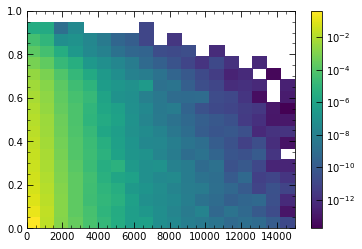

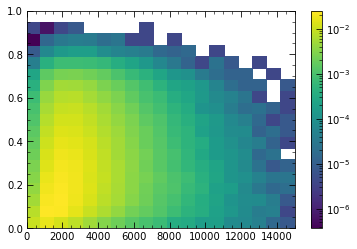

In [29]:
weights = reweighter("FS0", 0.0, subtract_sm=False)

bins = (np.linspace(0, 15000, 20), np.linspace(0, 1, 20))

var_1 = df["sT"]
var_2 = sphericity

plt.hist2d(var_1, var_2, bins,
           weights= weights / np.sum(weights),
           density=False,
           norm=LogNorm())
plt.colorbar()
plt.show()

weights = reweighter("FT0", 10.0, subtract_sm=True)

plt.hist2d(var_1, var_2, bins,
           weights= weights / np.sum(weights),
           density=False,
          norm=LogNorm())
plt.colorbar()
plt.show()

In [30]:
m_vvv_bins = np.linspace(1000, 8000, 200)

hist_sm = np.histogram(data["LHE_mVVV"], bins=m_vvv_bins, weights=reweighter("FT0", 0.0))[0]
hist_eft = np.histogram(data["LHE_mVVV"], bins=m_vvv_bins, weights=reweighter("FT0", 100.0, subtract_sm=True))[0]

hist_reweight = np.concatenate([[0.], hist_eft/hist_sm, [0.]])

m_vvv_reweight = hist_reweight[np.digitize(data["LHE_mVVV"], m_vvv_bins)]
m_vvv_clip = np.logical_and(data["LHE_mVVV"] > m_vvv_bins[0], data["LHE_mVVV"] < m_vvv_bins[-1])

In [37]:
weights = [
           reweighter("FT0", 0.0),
           reweighter("FT0", 100.0, subtract_sm=True),
           reweighter("FT1", 100.0, subtract_sm=True),
           reweighter("FT2", 100.0, subtract_sm=True)

          ]
labels = [
          "SM",
          "FT0_100",
          "FT1_100",
          "FT2_100"
         ]

In [32]:
weights = [
           #reweighter("FT0", 0.0),
           reweighter("FT0", 0.0) * m_vvv_reweight,
           reweighter("FT0", 100.0, subtract_sm=True) * m_vvv_clip,
           reweighter("FT1", 100.0, subtract_sm=True) * m_vvv_clip,
           reweighter("FT2", 100.0, subtract_sm=True) * m_vvv_clip

          ]
labels = [
          "SM",
          "FT0_100",
          "FT1_100",
          "FT2_100"
         ]

In [38]:
bins = m_vvv_bins

#variable = df["sT"]
variable = data["LHE_mVVV"]

for weight, label in zip(weights, labels):
    make_hist(variable, bins=bins, weights=weight, label=label, density=True)

plt.legend(loc="upper right", ncol=1)
plt.gca().set_yscale('log')
plt.ylabel("a.u.")
plt.title("Validation of dim. 8 weights in VVV")
plt.xlabel(r"$S_T$ [GeV] (sum of lepton, jet and MET pt without any selection)")
plt.savefig("plots/m_vvv.pdf")
plt.savefig("plots/m_vvv.png")
plt.close()

In [39]:
bins = np.linspace(0, 10000, 200)

#variable = df["sT"]
variable = data["philip_variable"]

for weight, label in zip(weights, labels):
    make_hist(variable, bins=bins, weights=weight, label=label, density=True)

plt.legend(loc="upper right", ncol=1)
plt.gca().set_yscale('log')
plt.ylabel("a.u.")
plt.title("Validation of dim. 8 weights in VVV")
plt.xlabel(r"inv. mass variable [GeV]")
plt.savefig("plots/inv_mass_variable.pdf")
plt.savefig("plots/inv_mass_variable.png")
plt.close()

In [40]:
bins = np.linspace(0, 1, 200)

 
mask = df["sT"].values > 0
variable = sphericity[mask]

for weight, label in zip(weights, labels):
    make_hist(variable, bins=bins, weights=weight[mask], label=label, density=True)
    
#plt.legend(loc="lower left", ncol=2)
plt.gca().set_yscale('log')
plt.ylabel("a.u.")
plt.title("Validation of dim. 8 weights in VVV")
plt.xlabel(r"sphericity")
plt.savefig("plots/sphericity.pdf")
plt.savefig("plots/sphericity.png")
plt.close()

In [41]:
for col in ["LHEWZ_etadiff", "LHEWZ_phidiff", "LHEWZ_deltaR",
                 "LHEWW_etadiff", "LHEWW_phidiff", "LHEWW_deltaR"]:
    
    

    bins = np.linspace(0, 10, 200)
    if "deltaR" in col:
        bins = np.linspace(0, 10, 200)

    #mask = df["sT"].values > 0
    variable = np.abs(data[col].flatten())#[mask]
    #variable = data["LHEWW_phidiff"][mask]


    for weight, label in zip(weights, labels):
        #make_hist(variable, bins=bins, weights=np.repeat(weight, 2), label=label, density=True)
        make_hist(variable, bins=bins, weights=np.repeat(weight, len(variable)//len(weight)),
                  label=label, density=True)

    plt.legend(loc="upper right", ncol=1)
    #plt.gca().set_yscale('log')
    plt.ylabel("a.u.")
    #plt.title("Validation of dim. 8 weights in VVV")
    plt.xlabel(col)
    plt.savefig(f"plots/{col}.pdf")
    plt.savefig(f"plots/{col}.png")
    plt.close()